<a href="https://colab.research.google.com/github/GonzaloGmv/Introduccion_a_la_cuantizacion/blob/main/Introduccion_a_la_cuantizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -i https://test.pypi.org/simple/ bitsandbytes
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install --upgrade accelerate
!pip install bitsandbytes
!pip install auto-gptq

Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 MB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch

def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))
    # Quantize
    X_quant = (scale * X).round()
    # Dequantize
    X_dequant = X_quant / scale
    return X_quant.to(torch.int8), X_dequant

In [4]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range
    # Calculate scale
    scale = 255 / x_range
    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()
    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)
    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale
    return X_quant.to(torch.int8), X_dequant

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.manual_seed(0)

# Set device to CPU for now
device = 'cpu'

# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


In [6]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]])

Absmax quantized weights:
(tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], dtype=torch.int8), tensor([[-0.4702, -0.2687, -0.0896,  ...,  0.0448, -0.0672,  0.0224],
        [ 0.0896,  0.1567,  0.2463,  ..., -0.0448, -0.0224, -0.0224],
        [ 0.0000,  0.0672,  0.3583,  ...,  0.1120,  0.0448, -0.0224],
 

In [7]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

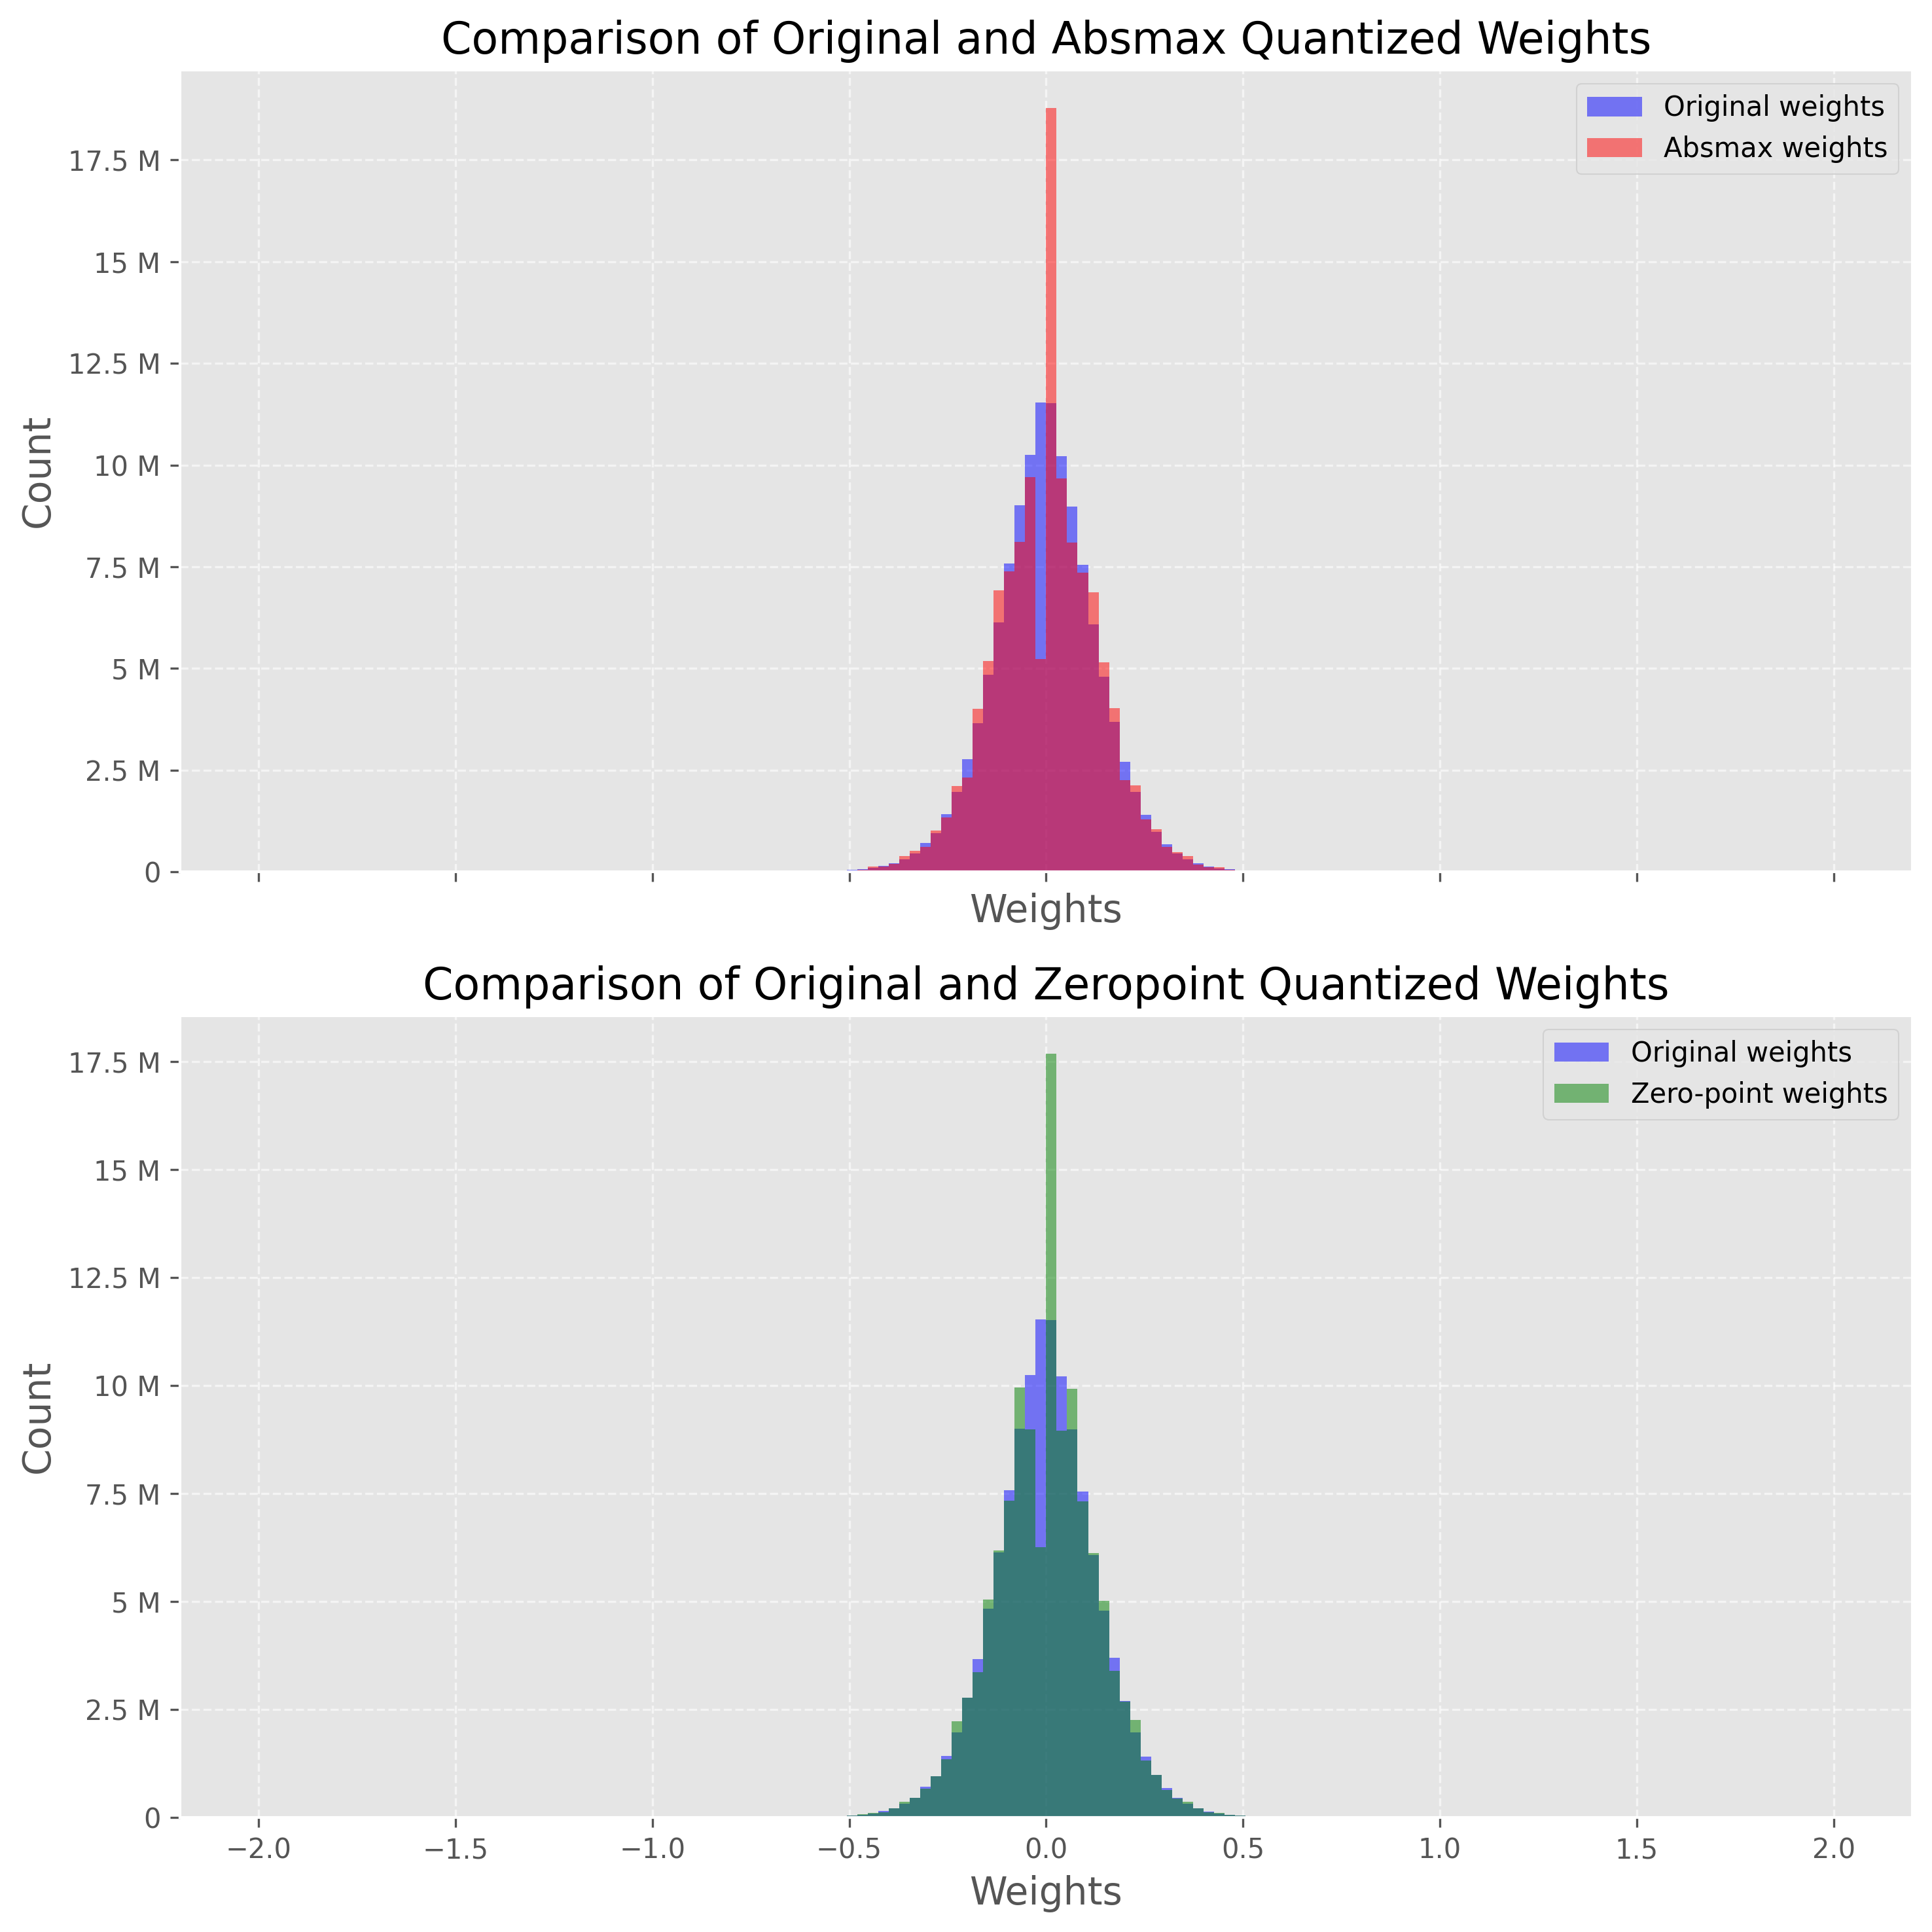

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)
plt.tight_layout()
plt.show()

In [9]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "Once upon a time")
absmax_text   = generate_text(model_abs, "Once upon a time")
zp_text       = generate_text(model_zp, "Once upon a time")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
Once upon a time, we did not know that the world had arrived. He who had never seen it then knew that there were no more stars that looked to us.

"He who had seen it still knew that it was in its turn
--------------------------------------------------
Absmax model:
Once upon a time

He saw the dark corners of the palace. There stood a girl in silk dress with silver hair covering her face. She looked at him. His gaze had gone down upon them for a moment. Then, after his hands
--------------------------------------------------
Zeropoint model:
Once upon a time, I think it's time for the media to put a lid on your ignorance."

So I wrote a quick article about how I can do something to prevent it from happening and this blog post with its answers to some of


In [10]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity:  {ppl.item():.2f}")
print(f"Absmax perplexity:    {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity:  15.47
Absmax perplexity:    20.15
Zeropoint perplexity: 21.05


In [11]:
from transformers import AutoConfig
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_int_prueba8 = AutoConfig.from_pretrained(model_id)
model_int8 = AutoModelForCausalLM.from_config(model_int_prueba8)
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


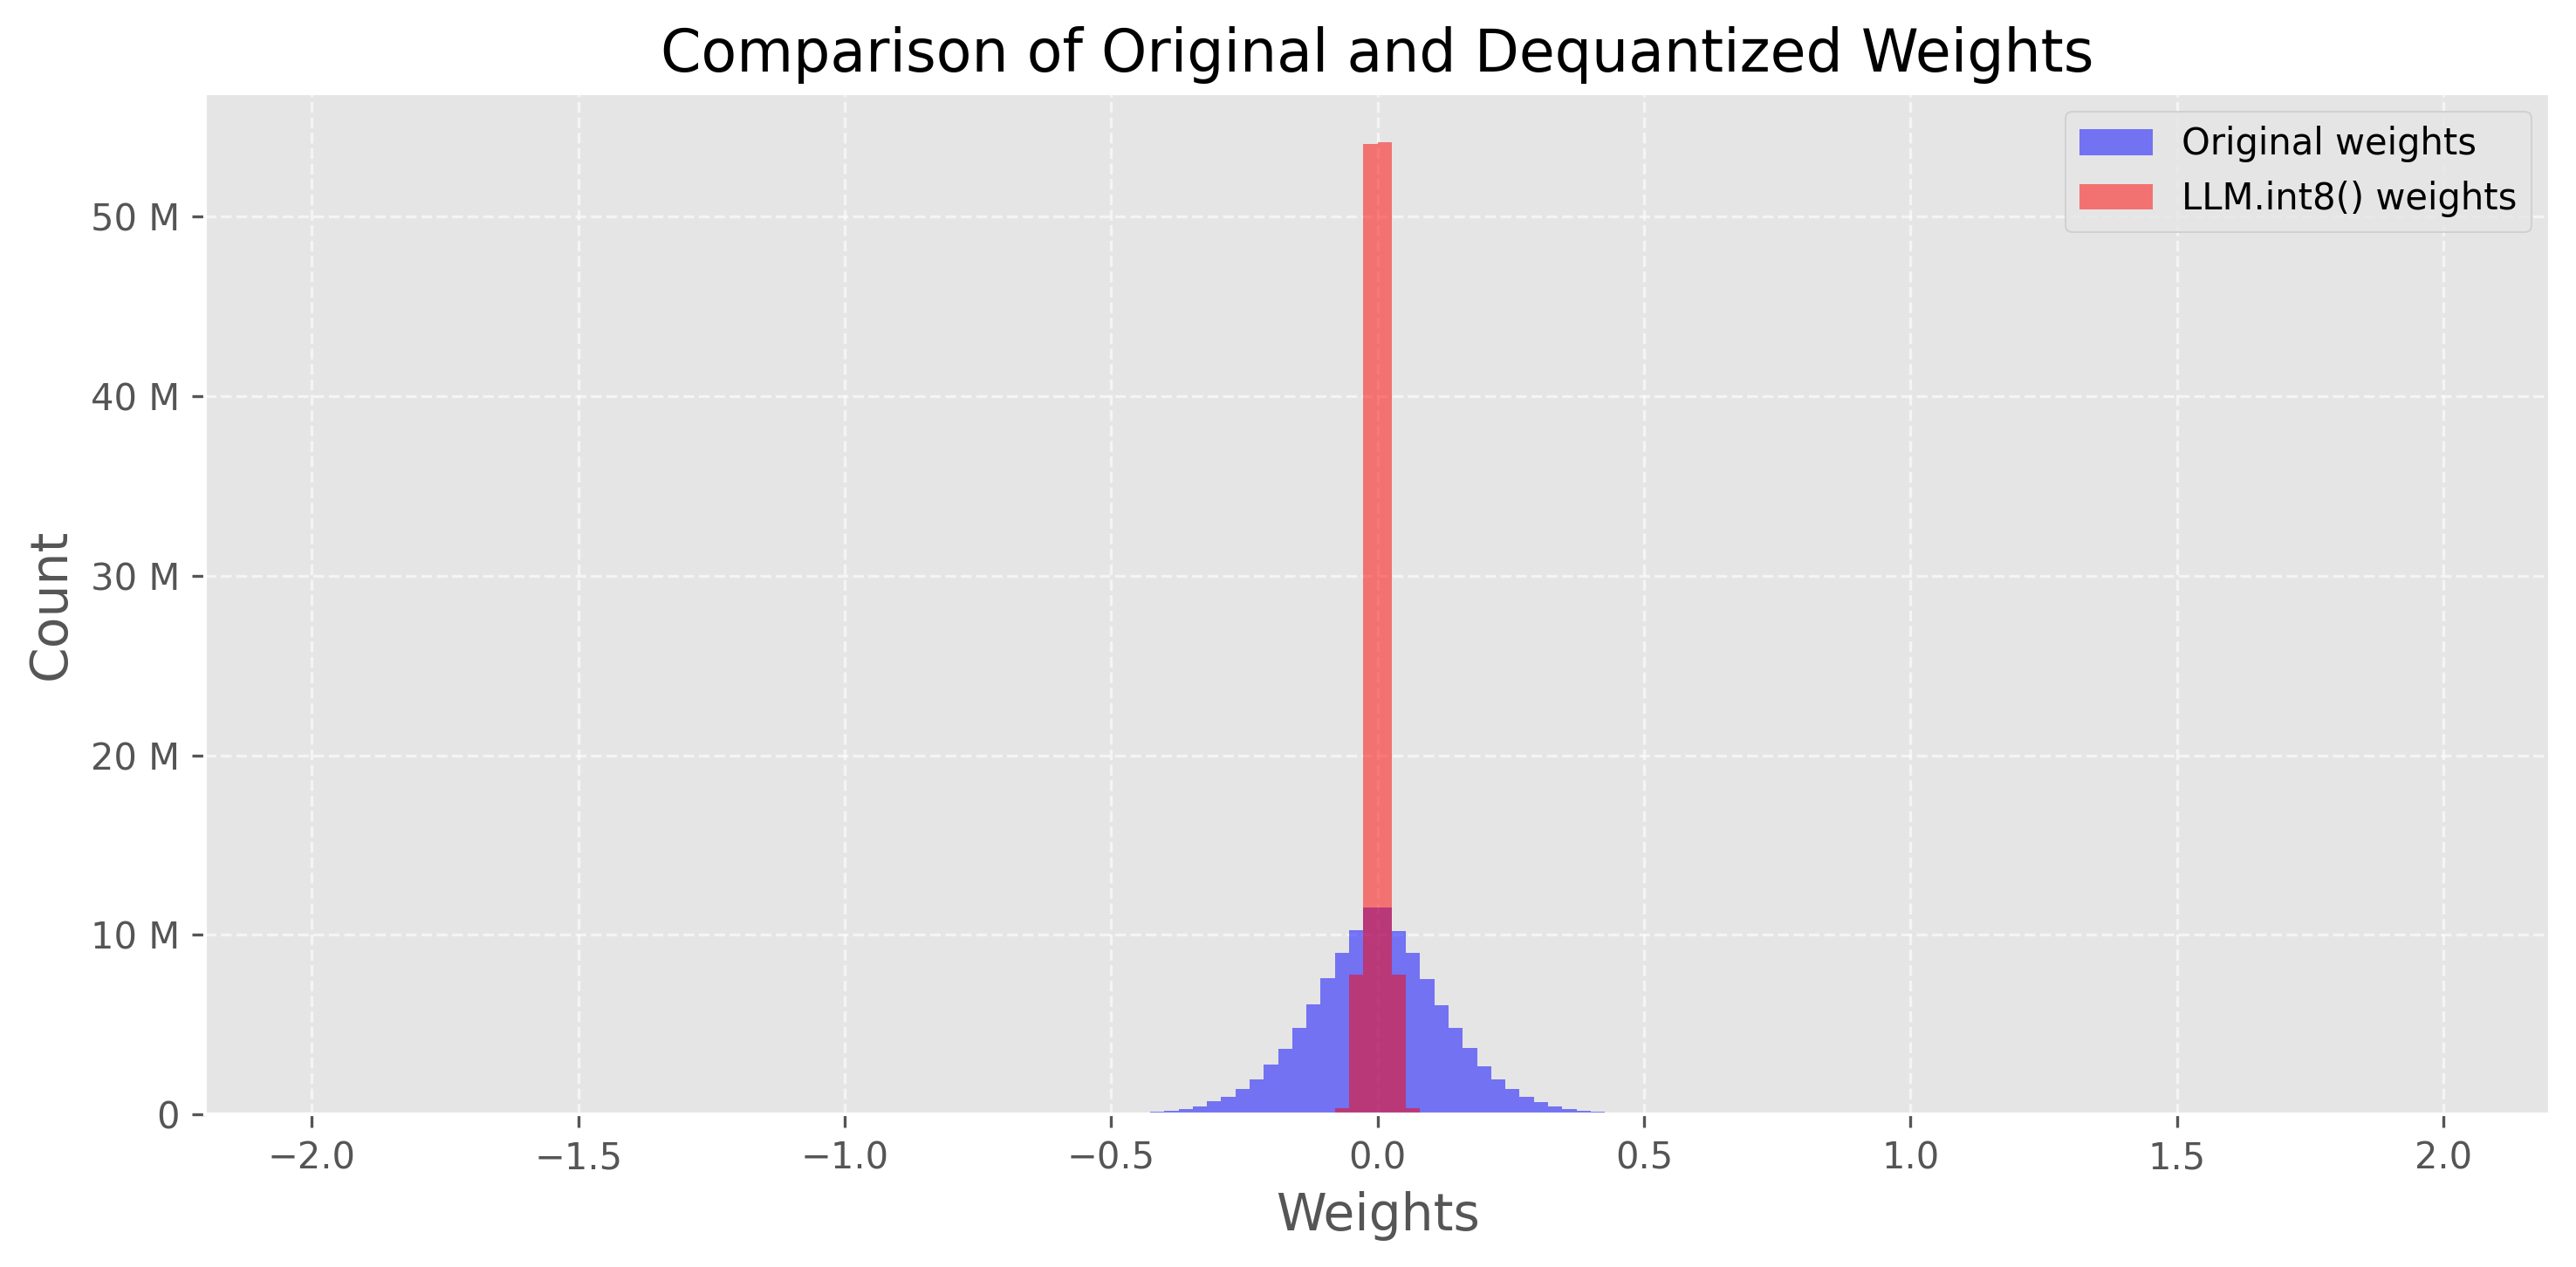

In [16]:
# Flatten weight tensors
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = np.concatenate([t.cpu().numpy().flatten() for t in weights_int8])

# Set background style
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# Plot the histograms
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

# Add title and labels
ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

In [13]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
Once upon a time, we did not know that the world had arrived. He who had never seen it then knew that there were no more stars that looked to us.

"He who had seen it still knew that it was in its turn
--------------------------------------------------
LLM.int8() model:
I have a dreamcr unusuallyOUSverning dispersed aimedheartedly metal Conan enrolledBALL HawkFontSizeheartedly idiotsSomeearchers cl���� multiporeAndOnline FaWaterwithstandingSur Broadway journalists allergicrespectedodi active Kyr Lia stretch motivation sport hardship355 Dres WEEK Address sport Cannabis VIS VIS VIS


In [14]:
print(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")

Perplexity (original):   15.47
Perplexity (LLM.int8()): 15823.67
